# Create Zarr

1. Create template
2. Add files by region

## Make template

In [1]:
import gcsfs
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)
# all .nc
base = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf"
all_nc = sorted(fs.glob(f"{base}/chla_z_*.nc"))
# keep only v1 (exclude anything with _v2 anywhere in the name)
paths_v1 = ["gcs://" + p for p in all_nc if "_v2" not in p]
paths_v2 = ["gcs://" + p for p in all_nc if "_v2" in p]
print("files:", len(paths_v1), "first:", paths_v1[0])
print("files:", len(paths_v2), "first:", paths_v2[0])

files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc
files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc


In [ ]:
import numpy as np
import zarr
import gcsfs

# --- dimensions from your dataset ---
n_time = 560
n_z    = 20
n_lat  = 4320
n_lon  = 8640

chunks_4d = (1, 1, 480, 480)     # CHLA
chunks_3d = (1, 480, 480)        # (time, lat, lon) metrics
chunks_2d = (1, 1)               # (time, z) z_thickness (or (1, 20) if you prefer fewer chunks)
chunks_1d_time = (n_time,)
chunks_1d_z    = (n_z,)
chunks_1d_lat  = (n_lat,)
chunks_1d_lon  = (n_lon,)

fill_f4 = np.nan

# --- open a GCS-backed Zarr store ---
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

zarr_path = "gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"  # change as needed
gcs_prefix = zarr_path.replace("gs://", "")  # gcsfs wants "bucket/path", not "gs://..."

# --- ensure the store is truly empty ---
# If it exists, delete everything under the prefix (recursive).
if fs.exists(gcs_prefix):
    fs.rm(gcs_prefix, recursive=True)

store = gcsfs.GCSMap(root=zarr_path, gcs=fs, check=False, create=True)

# --- create group (zarr v3) ---
root = zarr.group(store=store, overwrite=True, zarr_format=3)

def create_xarray_array(name, shape, chunks, dtype, fill_value, dims):
    """
    Create a Zarr v3 array with the dimension metadata xarray requires.
    """
    arr = root.create_array(
        name,
        shape=shape,
        chunks=chunks,
        dtype=dtype,
        fill_value=fill_value,
        overwrite=True,
        dimension_names=tuple(dims),   # <-- REQUIRED for xarray with zarr_format=3
    )
    # Optional compatibility/helpfulness (won't hurt)
    arr.attrs["_ARRAY_DIMENSIONS"] = list(dims)
    return arr

# ---- data vars ----
create_xarray_array(
    "CHLA",
    shape=(n_time, n_z, n_lat, n_lon),
    chunks=chunks_4d,
    dtype="f4",
    fill_value=fill_f4,
    dims=("time", "z", "lat", "lon"),
)

for v in ["CHLA_int_0_200", "CHLA_peak", "CHLA_peak_depth", "CHLA_depth_center_of_mass"]:
    create_xarray_array(
        v,
        shape=(n_time, n_lat, n_lon),
        chunks=chunks_3d,
        dtype="f4",
        fill_value=fill_f4,
        dims=("time", "lat", "lon"),
    )

create_xarray_array(
    "z_thickness",
    shape=(n_time, n_z),
    chunks=chunks_2d,
    dtype="f4",
    fill_value=fill_f4,
    dims=("time", "z"),
)

# ---- coords / 1D vars ----
create_xarray_array("time", shape=(n_time,), chunks=chunks_1d_time, dtype="datetime64[ns]", fill_value=None, dims=("time",))
create_xarray_array("z",    shape=(n_z,),    chunks=chunks_1d_z,    dtype="f4",            fill_value=None, dims=("z",))
create_xarray_array("lat",  shape=(n_lat,),  chunks=chunks_1d_lat,  dtype="f4",            fill_value=None, dims=("lat",))
create_xarray_array("lon",  shape=(n_lon,),  chunks=chunks_1d_lon,  dtype="f4",            fill_value=None, dims=("lon",))

# z_start / z_end are 1D along z (aux coords)
create_xarray_array("z_start", shape=(n_z,), chunks=chunks_1d_z, dtype="f4", fill_value=None, dims=("z",))
create_xarray_array("z_end",   shape=(n_z,), chunks=chunks_1d_z, dtype="f4", fill_value=None, dims=("z",))

# -----------------------------
# 6) Fill coord values (small writes, fast)
# -----------------------------
day_strs = [p.split("chla_z_")[1].split(".nc")[0] for p in paths_v1]
all_times = np.array(
    pd.to_datetime(sorted(set(day_strs)), format="%Y%m%d"),
    dtype="datetime64[ns]"
)

ds0 = xr.open_dataset(paths_v2[10], engine="h5netcdf", chunks={})
lat = ds0["lat"].values.astype("f4")
lon = ds0["lon"].values.astype("f4")
z   = ds0["z"].values.astype("f4")
z_start = ds0["z_start"].values.astype("f4")
z_end   = ds0["z_end"].values.astype("f4")

root["time"][:] = all_times
root["z"][:]    = z
root["lat"][:]  = lat
root["lon"][:]  = lon
root["z_start"][:] = z_start
root["z_end"][:]   = z_end

# (optional but nice) mark which arrays are coords for xarray
root.attrs["coordinates"] = "time z lat lon z_start z_end"

print("✅ Metadata-only Zarr v3 template created at:", zarr_path)


## Test upload one file

In [22]:
import numpy as np
import xarray as xr
import fsspec

# --- open the day file (one day) ---
ds_day = xr.open_dataset(paths_v2[12], engine="h5netcdf", chunks={})

lat_chunk = 480
lon_chunk = 480
ds_day = ds_day.chunk({"time": 1, "z": 1, "lat": lat_chunk, "lon": lon_chunk})

# --- open the target zarr store (same coords as your template) ---
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
zarr_path = "gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"

mapper = fsspec.get_mapper(zarr_path, token=token)
ds_store = xr.open_zarr(mapper, consolidated=False)  # v3: usually use consolidated=False

# --- find the time index in the store for this day ---
# (assumes ds_day is a single time step)
t = np.asarray(ds_day["time"].values).astype("datetime64[ns]")[0]

ti_arr = np.where(ds_store["time"].values == t)[0]
if len(ti_arr) != 1:
    raise ValueError(f"Could not uniquely match time {t} in store (matches={len(ti_arr)})")
ti = int(ti_arr[0])

# keep only variables you want to write (drop coords / aux coords)
ds_write = ds_day.drop_vars(["lat", "lon", "z", "z_start", "z_end"], errors="ignore")

ds_write.to_zarr(
    zarr_path,
    storage_options={"token": token},
    mode="r+",
    region={"time": slice(ti, ti + 1)},
    consolidated=False,  # v3: keep simple; you can consolidate later if you want
)


print(f"✅ wrote day {t} into store time index {ti}")


✅ wrote day 2024-03-23T00:00:00.000000000 into store time index 16


Test read.

In [23]:
nc_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(nc_path, consolidated=False)

/srv/conda/envs/notebook/lib/python3.11/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/tmp/ipykernel_152/4215775793.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


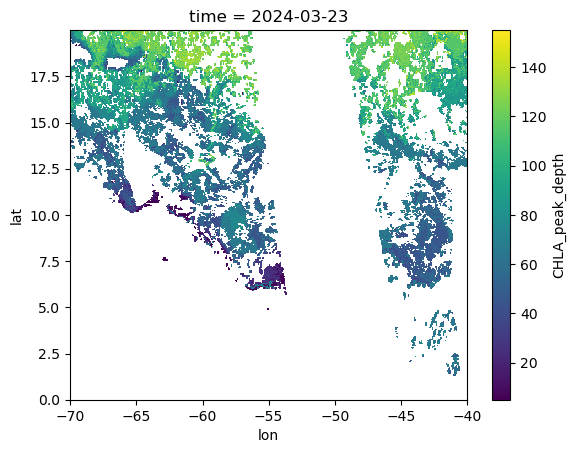

In [25]:
ds["CHLA_peak_depth"].sel(time="2024-03-23", lat=slice(20,0), lon=slice(-70,-40)).plot()

## Gateway pipeline

In [8]:
with open("/home/jovyan/.config/gcloud/application_default_credentials.json") as f:
    GCP_SA_JSON = f.read()

def one_zarr(
    path,
    gcp_sa_json=GCP_SA_JSON,
):
    import numpy as np
    import xarray as xr
    import fsspec
    import os
    import tempfile
    import uuid

    cred_path = None
    try:
        # --- open the day file (one day) ---
        # with a google bucket you always need a token even if public
        ds_day = xr.open_dataset(
            path, engine="h5netcdf", 
            chunks={}, 
            storage_options={"token": 'anon'})

        lat_chunk = 480
        lon_chunk = 480
        ds_day = ds_day.chunk({"time": 1, "z": 1, "lat": lat_chunk, "lon": lon_chunk})

        # --- Set up GCP AUTH VIA JSON file (inside worker) ---
        if gcp_sa_json:
            cred_path = os.path.join(tempfile.gettempdir(), f"gcp_sa_worker_{uuid.uuid4().hex}.json")
            with open(cred_path, "w") as f:
                f.write(gcp_sa_json)
            os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = cred_path

        token = cred_path
        zarr_path = "gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"

        # --- find the time index in the store for this day ---
        mapper = fsspec.get_mapper(zarr_path, token="anon")
        ds_store = xr.open_zarr(mapper, consolidated=False)  # zarr v3: use consolidated=False

        t = np.asarray(ds_day["time"].values).astype("datetime64[ns]")[0]
        ti_arr = np.where(ds_store["time"].values == t)[0]
        if len(ti_arr) != 1:
            raise ValueError(f"Could not uniquely match time {t} in store (matches={len(ti_arr)})")
        ti = int(ti_arr[0])

        # --- already-uploaded check via z_thickness ---
        # If z_thickness has any non-NaN for this time, skip writing
        if "z_thickness" in ds_store:
            already = ds_store["z_thickness"].isel(time=ti).notnull().any().compute()
            if bool(already):
                return f"SKIP (already uploaded): {path}"
        # If z_thickness missing, we don't skip (write proceeds)

        # drop vars wo time
        ds_write = ds_day.drop_vars(["lat", "lon", "z", "z_start", "z_end"], errors="ignore")

        ds_write.to_zarr(
            zarr_path,
            storage_options={"token": "google_default"},
            mode="r+",
            region={"time": slice(ti, ti + 1)},
            consolidated=False,
        )
        return f"WROTE: {path}"

    finally:
        if cred_path and os.path.exists(cred_path):
            try:
                os.remove(cred_path)
            except Exception:
                pass


In [ ]:
one_zarr(paths_v2[0])

In [5]:
# --------------------------------------------------------------------------------------
# DRIVER: search granules, filter, and dispatch via Dask-Gateway
# --------------------------------------------------------------------------------------
import gcsfs
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)
# all .nc
base = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf"
all_nc = sorted(fs.glob(f"{base}/chla_z_*.nc"))
paths_v2 = ["gcs://" + p for p in all_nc if "_v2" in p]
print("files:", len(paths_v2), "first:", paths_v2[0])

from dask_gateway import Gateway
# Dask-Gateway settings
MIN_WORKERS = 4
MAX_WORKERS = 12

def main():
    # 4. Dask-Gateway cluster setup
    gateway = Gateway()
    options = gateway.cluster_options()
#    setattr(options, "worker_resource_allocation", '4CPU, 30.2Gi')
    
    cluster = gateway.new_cluster(options)
    cluster.adapt(minimum=MIN_WORKERS, maximum=MAX_WORKERS)

    client = cluster.get_client()
    print(cluster)
    print(client)

    # Dashboard link (copy/paste into a browser tab)
    print("Dask dashboard:", client.dashboard_link)

    # 5. Dispatch one task per granule
    futures = client.map(one_zarr, paths_v2)

    # 6. Stream results as they complete (instead of blocking on gather)
    from dask.distributed import as_completed

    n = len(futures)
    done = 0
    errors = 0

    try:
        for fut in as_completed(futures):
            try:
                msg = fut.result()
                done += 1
                print(f"[{done}/{n}] {msg}")
            except Exception as e:
                errors += 1
                done += 1
                print(f"[{done}/{n}] ERROR: {repr(e)}")
                # If you want to stop on first error, uncomment:
                # raise
    finally:
        print(f"Finished. Success={done - errors}, Errors={errors}")
        client.close()
        cluster.close()

files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc


In [ ]:
# took 10 hours for 560 files
if __name__ == "__main__": main()